#### Time Series Model 

In [60]:
import numpy as np
import pandas as pd

In [61]:
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt

In [62]:
data=pd.read_csv('Airpassengers.csv')
# data:

In [63]:
data.head(2)

,Month,#Passengers
0,1949-01,112
1,1949-02,118


In [64]:
#data['Month']=pd.to_datetime(data['Month'])

In [65]:
data['Month']=data['Month'].apply(lambda x: dt(int(x[0:4]),int(x[5:]),9)) # dt(year,month,date)

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null datetime64[ns]
#Passengers    144 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.3 KB


In [67]:
data.set_index('Month',inplace=True)

In [68]:
data.head(2)

,#Passengers
Month,
1949-01-09,112
1949-02-09,118


In [69]:
ts=data['#Passengers']

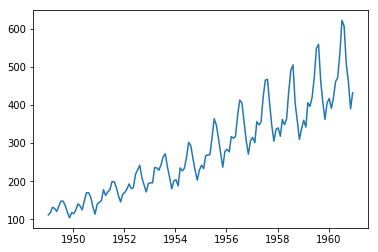

In [70]:
plt.plot(ts)

In [71]:
## trend and seasonality is there. Non stationary data

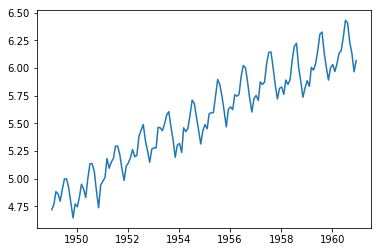

In [72]:
# convert non stationary to stationary
# transformation
ts_log=np.log(ts)
plt.plot(ts_log)

In [73]:
#from statsmodels.tsa.stattools
#import adfuller
def adf_test(timeseries):
    print('results of Dickey-Fuller Test:')
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['teststatistic','pvalue','lags used','no of observationsused'])
    for key, value in dftest[4].items():
        dfoutput['critical value(%s)'%key]=value
    print(dfoutput)
    #print(dftest)
#apply adf test on the series\
#adf_test(ts['#Passengers'])

In [74]:
adf_test(data['#Passengers'])

results of Dickey-Fuller Test:
teststatistic               0.815369
pvalue                      0.991880
lags used                  13.000000
no of observationsused    130.000000
critical value(1%)         -3.481682
critical value(5%)         -2.884042
critical value(10%)        -2.578770
dtype: float64


In [75]:
movingavg=ts_log.rolling(window=12).mean()
movingstd=ts_log.rolling(window=12).std()

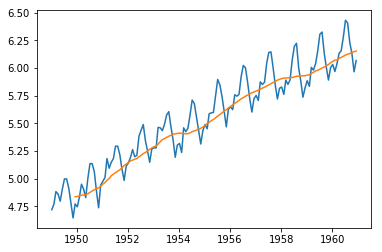

In [76]:
plt.plot(ts_log)
plt.plot(movingavg)

In [77]:
ts_log_mv_diff=ts_log-movingavg

In [78]:
ts_log_mv_diff.head()

Month
1949-01-09   NaN
1949-02-09   NaN
1949-03-09   NaN
1949-04-09   NaN
1949-05-09   NaN
Name: #Passengers, dtype: float64

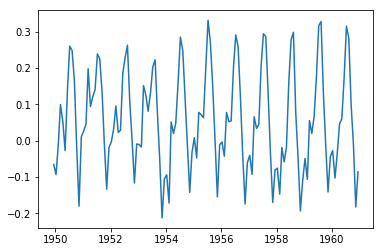

In [79]:
plt.plot(ts_log_mv_diff)

In [80]:
ts_log_mv_diff.dropna(inplace=True)

In [81]:
ts_log_mv_diff.head(2)

Month
1949-12-09   -0.065494
1950-01-09   -0.093449
Name: #Passengers, dtype: float64

In [82]:
adf_test(ts_log_mv_diff)

results of Dickey-Fuller Test:
teststatistic              -3.162908
pvalue                      0.022235
lags used                  13.000000
no of observationsused    119.000000
critical value(1%)         -3.486535
critical value(5%)         -2.886151
critical value(10%)        -2.579896
dtype: float64


In [83]:
ts_log_mv_diff.mean()

0.054873771109195106

In [84]:
ts_log_mv_diff.var()

0.018232743240213387

C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


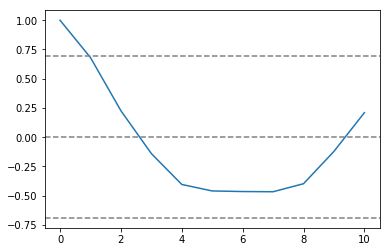

In [85]:
plt.plot(np.arange(0,11),acf(ts_log_mv_diff,nlags=10))### Q-error terms=MA
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--',color='gray')# threshold values (research)
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--',color='gray')

Whereever the curve touches the upper threshold line.
Q=1 or less than 1. i.e 0.
Q=1 or 0.

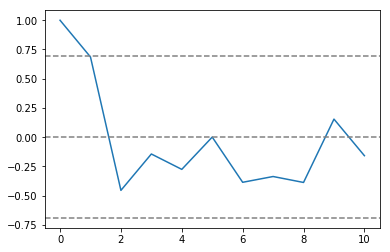

In [86]:
plt.plot(np.arange(0,11),pacf(ts_log_mv_diff,nlags=10))### P-->AR-> past values
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--',color='gray')# threshold values (research)
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--',color='gray')

In [87]:
#consider continuous flow from where to..(Where the acf curve touches the horizontal line +7.96 from where to flow goes)
# 1 to 2
#p=1 0r 2, Auto regressive

### ARMA Model

In [88]:
model=ARMA(ts_log_mv_diff,order=(1,0)) # can passover p=1,2, Q=0,1  order=(p,Q)

C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [89]:
results=model.fit()

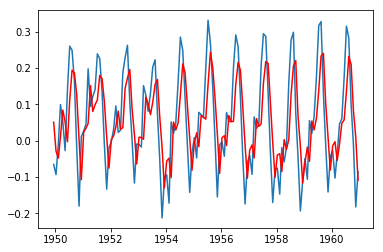

In [90]:
plt.plot(ts_log_mv_diff)
plt.plot(results.fittedvalues,color='red')

In [91]:
from sklearn.metrics import mean_squared_error
y_df = pd.DataFrame( {'Observed':ts_log_mv_diff.values, 'Predicted':results.fittedvalues})
y_df .dropna(axis = 0, inplace = True)
print(y_df.tail())

rmse = np.sqrt(mean_squared_error(y_df.Observed, y_df.Predicted))
print("\n\n Accuracy measures ")
print('RMSE: %.3f' % rmse)
n = y_df.shape[0]

            Observed  Predicted
Month                          
1960-08-09  0.282363   0.231966
1960-09-09  0.098235   0.209494
1960-10-09 -0.009230   0.083291
1960-11-09 -0.182690   0.009634
1960-12-09 -0.085789  -0.109256


 Accuracy measures 
RMSE: 0.098


### ARIMA model

In [92]:
from statsmodels.tsa.arima_model import ARIMA  ## 3 parameters :p,d,q

In [93]:
##d: how many times done the difference

In [94]:
model=ARIMA(ts_log_mv_diff,order=(1,1,1))

C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [95]:
results1=model.fit()

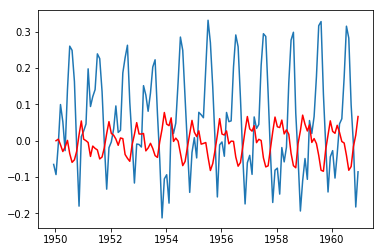

In [96]:
plt.plot(ts_log_mv_diff)
plt.plot(results1.fittedvalues,color='red')

In [110]:
from sklearn.metrics import mean_squared_error
y_df = pd.DataFrame( {'Observed':ts_log_mv_diff.values[:-1], 'Predicted':results1.fittedvalues})
y_df .dropna(axis = 0, inplace = True)
print(y_df.head())

rmse = np.sqrt(mean_squared_error(y_df.Observed, y_df.Predicted))
print("\n\n Accuracy measures ")
print('RMSE: %.3f' % rmse)
#n = y_df.shape[0]

            Observed  Predicted
Month                          
1950-01-09 -0.065494  -0.000193
1950-02-09 -0.093449   0.004009
1950-03-09 -0.007566  -0.011287
1950-04-09  0.099416  -0.029992
1950-05-09  0.052142  -0.017537


 Accuracy measures 
RMSE: 0.183
